# Ex07. 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅니다.

In [78]:
import pandas as pd
import re
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

In [2]:
import tensorflow

print(tensorflow.__version__)

2.6.0


# Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

- [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

In [3]:
data = pd.read_csv('./ChatbotData .csv')
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


- 총 11,823개의 샘플

- 하나의 문장(Q)과 그에 대한 반응 문장(A), 그리고 분위기 라벨(0: 일상, 1: 부정, 2: 긍정)로 이루어진 데이터셋.

- 우리는 여기서 Q, A만 사용하기로 한다.

# Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행합니다.

In [4]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (영문, 숫자, 한글, "?", "!")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub("[^0-9a-zA-Z가-힣?!]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

- 데이터가 모두 한 문장씩으로 이루어져 있으므로 "."이 의미가 없으니 삭제.
- 간혹 등장하는 숫자와 영단어가 있으므로 영어, 숫자 살림.
- "!", "?" 외의 특수문자는 불필요해 보이므로 삭제.
- 처리 전후 예시 확인

In [5]:
for i in [0, 3, 1398, 1972, 2060, 2692, 6665]:
    print(f'전: {data.loc[i, "Q"]} \n후: {preprocess_sentence(data.loc[i, "Q"])}')
    print("="*50)

전: 12시 땡! 
후: 12시 땡 !
전: 3박4일 정도 놀러가고 싶다 
후: 3박4일 정도 놀러가고 싶다
전: 떠나요~ 제주도~ 
후: 떠나요 제주도
전: 밥먹자. 
후: 밥먹자
전: 베터리 겨우 15%야 
후: 베터리 겨우 15 야
전: 스트레스~ 
후: 스트레스
전: 새출발, 트라우마 
후: 새출발 트라우마


- 전처리 진행 및 문답 분리

In [6]:
questions, answers = [], []

for i in range(len(data)):
    q, a, _ = data.loc[i]
    questions.append(preprocess_sentence(q))
    answers.append(preprocess_sentence(a))

In [7]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
idx = 2060
print(f'전처리 후의 {idx}번째 질문 샘플: {questions[idx]}')
print(f'전처리 후의 {idx}번째 답변 샘플: {answers[idx]}')

전처리 후의 2060번째 질문 샘플: 베터리 겨우 15 야
전처리 후의 2060번째 답변 샘플: 미리 충전하세요


# Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 `SubwordTextEncoder`를 그대로 사용합니다.

- [당신의 코드에서 2의 제곱수가 계속 보이는 이유](https://torchtorchkimtorch.tistory.com/3)

## Tokenizing & Integer Encoding

In [13]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**14)

In [15]:
tokenizer.vocab_size

21880

In [16]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2

print('VOCAB_SIZE :', VOCAB_SIZE)
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

VOCAB_SIZE : 21882
START_TOKEN의 번호 : [21880]
END_TOKEN의 번호 : [21881]


In [29]:
def get_tokenized(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)
        
    return tokenized_inputs, tokenized_outputs

In [30]:
tokenized_Q, tokenized_A = get_tokenized(questions, answers)

print(f'Tokenizing & Integer Encoding 후의 {idx}번째 질문 샘플: {tokenized_Q[idx]}')
print(f'Tokenizing & Integer Encoding 후의 {idx}번째 답변 샘플: {tokenized_A[idx]}')

Tokenizing & Integer Encoding 후의 2060번째 질문 샘플: [21880, 4691, 1979, 9664, 3303, 21881]
Tokenizing & Integer Encoding 후의 2060번째 답변 샘플: [21880, 484, 2051, 21881]


## 샘플 길이 설정

- 샘플들을 최대한 많이 학습 데이터로 사용하기 위해 최대 길이 확인

In [43]:
# 길이 분포 출력
def get_len_graph(questions, answers, encode=False):
    if encode:
        q_len = [len(s) for s in questions]
        a_len = [len(s) for s in answers]
    else:
        q_len = [len(s.split()) for s in questions]
        a_len = [len(s.split()) for s in answers]

    print('질문의 최소 길이 \t: {}'.format(np.min(q_len)))
    print('질문의 최대 길이 \t: {}'.format(np.max(q_len)))
    print('질문의 평균 길이 \t: {}'.format(np.mean(q_len)))
    print('답변의 최소 길이 \t: {}'.format(np.min(a_len)))
    print('답변의 최대 길이 \t: {}'.format(np.max(a_len)))
    print('답변의 평균 길이 \t: {}'.format(np.mean(a_len)))

    plt.subplot(1,2,1)
    plt.boxplot(q_len)
    plt.title('questions')
    plt.subplot(1,2,2)
    plt.boxplot(a_len)
    plt.title('answers')
    plt.tight_layout()
    plt.show()

    plt.title('questions')
    plt.hist(q_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

    plt.title('answers')
    plt.hist(a_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

질문의 최소 길이 	: 3
질문의 최대 길이 	: 18
질문의 평균 길이 	: 5.740505793791762
답변의 최소 길이 	: 3
답변의 최대 길이 	: 24
답변의 평균 길이 	: 5.721221348219572


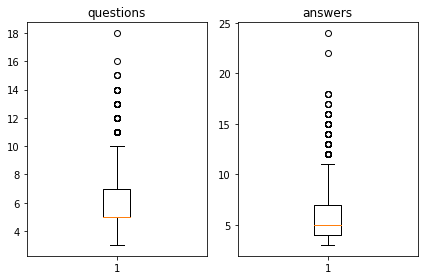

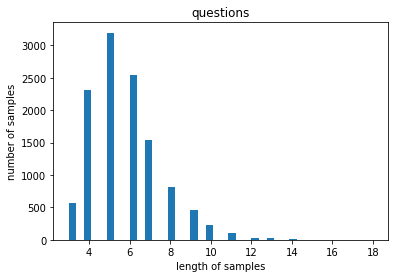

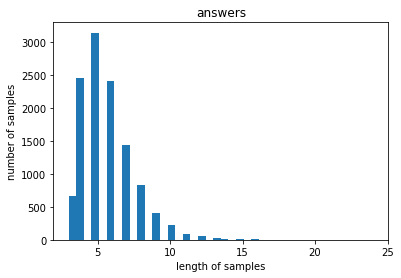

In [44]:
get_len_graph(tokenized_Q, tokenized_A, True)

In [46]:
MAX_LENGTH = 24

## Padding

In [52]:
def get_padding(tokenized_samples, max_length):
    padded_samples = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_samples, maxlen=max_length, padding='post')
    return padded_samples

In [54]:
tokenized_Q = get_padding(tokenized_Q, MAX_LENGTH)
tokenized_A = get_padding(tokenized_A, MAX_LENGTH)

print(f'패딩 후의 {idx}번째 질문 샘플: {tokenized_Q[idx]}')
print(f'패딩 후의 {idx}번째 답변 샘플: {tokenized_A[idx]}')

패딩 후의 2060번째 질문 샘플: [21880  4691  1979  9664  3303 21881     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]
패딩 후의 2060번째 답변 샘플: [21880   484  2051 21881     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


In [58]:
tokenized_Q.shape, tokenized_A.shape

((11823, 24), (11823, 24))

## Teacher Forcing

In [60]:
BATCH_SIZE = 64
BUFFER_SIZE = len(tokenized_Q)

# 디코더는 이전의 target을 다음의 input으로 사용.
# 이에 따라 outputs에서는 START_TOKEN을 제거.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': tokenized_Q,
        'dec_inputs': tokenized_A[:, :-1]
    },
    {
        'outputs': tokenized_A[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Step 4. 모델 구성하기

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

## Scaled Dot Product Attention

In [62]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

## Multi Head Attention

In [63]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query) # [[YOUR CODE]]
        key = self.key_dense(key) # [[YOUR CODE]]
        value = self.value_dense(value) # [[YOUR CODE]]

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size) # [[YOUR CODE]]
        key = self.split_heads(key, batch_size) # [[YOUR CODE]]
        value = self.split_heads(value, batch_size) # [[YOUR CODE]]

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

## Padding Masking

In [64]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## Positional Encoding

In [65]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        # positional_encoding 함수를 호출하여 포지셔널 인코딩 행렬을 생성하고 저장합니다.
        # position: 문장의 최대 길이 또는 임베딩될 수 있는 최대 위치의 수
        # d_model: 임베딩 벡터의 차원
        self.pos_encoding = self.positional_encoding(position, d_model)

    # 각도(angle)를 계산하는 함수입니다.
    # position: 현재 단어의 위치
    # i: 임베딩 벡터 내의 차원 인덱스
    # d_model: 임베딩 벡터의 차원
    def get_angles(self, position, i, d_model):
        # 10000의 (2 * (i // 2)) / d_model 제곱으로 나누어지는 값을 계산합니다.
        # 이는 주파수가 점차 감소하는 사인 및 코사인 함수의 주기를 결정합니다.
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        # 현재 위치와 계산된 각도를 곱하여 최종 각도 값을 얻습니다.
        return position * angles

      
    # 포지셔널 인코딩 행렬을 생성하는 함수입니다.
    # position: 문장의 최대 길이 또는 임베딩될 수 있는 최대 위치의 수
    # d_model: 임베딩 벡터의 차원
    def positional_encoding(self, position, d_model):
        # 각도 배열을 생성합니다.
        # position 축에는 0부터 position-1까지의 값을 가집니다.
        # i 축에는 0부터 d_model-1까지의 값을 가집니다.
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스(2i)에는 사인 함수를 적용합니다.
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수를 적용합니다.
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # 사인과 코사인 값을 번갈아 가며 쌓습니다.
        pos_encoding = tf.stack([sines, cosines], axis=0)
        # [2, position, d_model/2] 형태를 [position, d_model/2, 2] 형태로 transpose 합니다.
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
        # [position, d_model/2, 2] 형태를 [position, d_model] 형태로 reshape 합니다.
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        # 배치 차원을 추가하여 [1, position, d_model] 형태로 만듭니다.
        pos_encoding = pos_encoding[tf.newaxis, ...]
        # 데이터 타입을 float32로 변환하여 반환합니다.
        return tf.cast(pos_encoding, tf.float32)
    
    
        # Layer의 call 메소드입니다. 입력 텐서에 포지셔널 인코딩을 더하여 반환합니다.
        # inputs: 입력 텐서 (일반적으로 단어 임베딩)
    def call(self, inputs):
        # 입력 텐서의 두 번째 차원(sequence length)만큼 포지셔널 인코딩을 잘라서 더합니다.
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## Encoder

In [66]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({'query': inputs,
                                               'key': inputs,
                                               'value': inputs,
                                               'mask': padding_mask})

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name="encoder_layer_{}".format(i), )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Decoder

In [67]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : look_ahead_mask를 사용한 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={'query': inputs,
                                                        'key': inputs,
                                                        'value': inputs,
                                                        'mask': look_ahead_mask})

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 
    # 인코더 출력을 Key와 Value로 사용한 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={'query': attention1,
                                                        'key': enc_outputs,
                                                        'value': enc_outputs,
                                                        'mask': padding_mask})

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs, name=name)



In [68]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name='decoder_layer_{}'.format(i),
                                )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs, name=name)

## Transformer

In [69]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,
                          )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Modeling

In [70]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    6656000     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## Loss function

In [71]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

## Learning rate

In [72]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

## Compile

In [73]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## Train

In [79]:
EPOCHS = 15
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/15
185/185 [==============================] - 43s 71ms/step - loss: 1.9297 - accuracy: 0.0374
Epoch 2/15
185/185 [==============================] - 13s 71ms/step - loss: 1.6092 - accuracy: 0.0435
Epoch 3/15
185/185 [==============================] - 13s 71ms/step - loss: 1.3962 - accuracy: 0.0435
Epoch 4/15
185/185 [==============================] - 13s 72ms/step - loss: 1.3018 - accuracy: 0.0455
Epoch 5/15
185/185 [==============================] - 14s 73ms/step - loss: 1.2103 - accuracy: 0.0509
Epoch 6/15
185/185 [==============================] - 13s 73ms/step - loss: 1.1224 - accuracy: 0.0563
Epoch 7/15
185/185 [==============================] - 13s 72ms/step - loss: 1.0261 - accuracy: 0.0639
Epoch 8/15
185/185 [==============================] - 13s 72ms/step - loss: 0.9205 - accuracy: 0.0743
Epoch 9/15
185/185 [==============================] - 13s 72ms/step - loss: 0.8068 - accuracy: 0.0874
Epoch 10/15
185/185 [==============================] - 13s 72ms/step - loss: 0.688

# Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [89]:
def decoder_inference(sentence):
    # 1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
    sentence = preprocess_sentence(sentence)

    # 2. 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장.
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

def sentence_generation(sentence, show=True):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    if show:
        print('입력 : {}'.format(sentence))
        print('출력 : {}'.format(predicted_sentence))
    else:
        return predicted_sentence


In [108]:
def compare2original(start_idx, num_samples):
    for idx in range(start_idx, start_idx + num_samples):
        q, a, _ = data.loc[idx]
        print(f"입  력: {q}")
        print(f"원본답: {a}")
        print(f"모델답: {sentence_generation(q, False)}")
        print("="*50)

In [143]:
def conversation_mode():
    prompt = input("나:")
    
    while prompt != "EOC":
        print(f"봇: {sentence_generation(prompt, False)}")
        prompt = input("나:")
    print("End of Conversation")

## 원본 데이터와 비교 평가

In [109]:
compare2original(50, 10)

입  력: 감 말랭이 먹어야지
원본답: 맛있게 드세요.
모델답: 맛있게 드세요
입  력: 감기 같애
원본답: 병원가세요.
모델답: 이럴 때 잘 쉬는 게 중요해요
입  력: 감기 걸린 것 같아
원본답: 이럴 때 잘 쉬는 게 중요해요.
모델답: 이럴 때 잘 쉬는 게 중요해요
입  력: 감기 기운이 있어
원본답: 이럴 때 잘 쉬는 게 중요해요.
모델답: 이럴 때 잘 쉬는 게 중요해요
입  력: 감기 들 거 같애
원본답: 이럴 때 잘 쉬는 게 중요해요.
모델답: 이럴 때 잘 쉬는 게 중요해요
입  력: 감기가 오려나
원본답: 따뜻하게 관리하세요.
모델답: 따뜻하게 관리하세요
입  력: 감기약이 없어
원본답: 병원가세요.
모델답: 병원가세요
입  력: 감기인거 같애
원본답: 병원가세요.
모델답: 병원가세요
입  력: 감미로운 목소리 좋아
원본답: 저도 듣고 싶네요.
모델답: 저도 듣고 싶네요
입  력: 감정이 쓰레기통처럼 엉망진창이야
원본답: 자신을 더 사랑해주세요.
모델답: 자신을 더 사랑해주세요


In [110]:
compare2original(150, 10)

입  력: 결혼식때 하객이 없을 까봐 걱정돼
원본답: 생각보다 신경 안 씁니다.
모델답: 생각보다 신경 안 씁니다
입  력: 결혼식이 너무 많아
원본답: 인맥이 넓으신가봐요.
모델답: 인맥이 넓으신가봐요
입  력: 결혼이나 하지 왜 자꾸 나한테 화 내냐구!
원본답: 힘들겠네요.
모델답: 힘들겠네요
입  력: 결혼준비 돈 많이 들겠지
원본답: 많이 들지만 줄일 수 있을 거예요.
모델답: 많이 들지만 줄일 수 있을 거예요
입  력: 결혼준비하는데 돈 얼마나 드나
원본답: 욕심에 따라 천지 차이일 거예요.
모델답: 욕심에 따라 천지 차이일 거예요
입  력: 결혼하는데 돈 많이 드네
원본답: 허례허식이에요.
모델답: 허례허식이에요
입  력: 결혼하는데 돈 얼마나 들까
원본답: 욕심에 따라 천지 차이일 거예요.
모델답: 욕심에 따라 천지 차이일 거예요
입  력: 결혼하면 좋아?
원본답: 해봐요.
모델답: 서로 노력하면 행복할 거예요
입  력: 결혼하면 좋을까
원본답: 서로 노력하면 행복할 거예요.
모델답: 서로 노력하면 행복할 거예요
입  력: 결혼하면 행복할까?
원본답: 서로 노력하면 행복할 거예요.
모델답: 서로 노력하면 행복할 거예요


- 과적합인가 싶을 정도로 원본답과 대부분 동일한 대답을 출력한다.
- 10개 중 1개씩 원본과 다른 답이 나왔지만 맥락상 충분히 적절한 답을 출력해냈다.
    - 사실 이 부분은 유사한 질문과 답이 반복되며 나타나는 현상으로 보인다.

## 새로운 문장 입력

### 주제: 없음. (무작위 입력)

In [90]:
sentence_generation('이게 잘 될까?')

입력 : 이게 잘 될까?
출력 : 사랑은 때론 잔인하죠


- 생뚱맞은 답변.
    - 다소 억지스럽게 긍정적으로 평가해보자면, 데이터셋이 주로 사랑이나 이별 관련 내용이다보니 "이게"를 "사랑" 혹은 "연애" 등으로 해석한다면 나름 해줄법한 답변이긴 하다.

In [112]:
sentence_generation('답변이 잘 나올까?')

입력 : 답변이 잘 나올까?
출력 : 그건 좀 힘들 거예요


- 역설적이게도 그럴싸한 답변.

In [113]:
sentence_generation('오늘은 날씨가 좋으려나')

입력 : 오늘은 날씨가 좋으려나
출력 : 무슨 일이 있었나봐요


- 날씨에 대한 답변을 기대했으나 다른 답변이 나옴.
- 그러나 뭔가 감성적으로는 그럴싸한 답변.

In [94]:
sentence_generation('야')

입력 : 야
출력 : 네


In [111]:
sentence_generation('쉬고 싶다')

입력 : 쉬고 싶다
출력 : 잠깐 핸드폰을 내려두세요


### 주제: 음식

- 좋은 사례

In [123]:
sentence_generation('피자 먹고싶다')

입력 : 피자 먹고싶다
출력 : 같이 먹어요 !


In [135]:
sentence_generation('와! 여기 짜장면 맛있어')

입력 : 와! 여기 짜장면 맛있어
출력 : 한 잔 하세요


In [129]:
sentence_generation('짜장면 맛있어')

입력 : 짜장면 맛있어
출력 : 짜장면은 혼자 먹어도 맛있어요


- 나쁜 사례

In [124]:
sentence_generation('점심 먹으러 가고싶다')

입력 : 점심 먹으러 가고싶다
출력 : 진심으로 다가가면 친구가 될 수 있을 거예요


In [125]:
sentence_generation('넌 무슨 음식 좋아해?')

입력 : 넌 무슨 음식 좋아해?
출력 : 안 좋은 회사네요


In [136]:
sentence_generation('치킨 좋아해?')

입력 : 치킨 좋아해?
출력 : 즐거운 주말 보내실 것 같네요


### 주제: 스포츠

In [137]:
sentence_generation('축구하러 갈래?')

입력 : 축구하러 갈래?
출력 : 저 나가면 될까요 ?


In [138]:
sentence_generation('야구 보는게 좋아? 하는게 좋아?')

입력 : 야구 보는게 좋아? 하는게 좋아?
출력 : 그럼요 한 잔 하세요


In [139]:
sentence_generation('농구 재미있다')

입력 : 농구 재미있다
출력 : 새로운 도전은 용기가 필요하죠


### 주제: 연애

In [144]:
conversation_mode()

나:친구가 짝사랑 중이야
봇: 친구가 들으면 서운해 할 수도 있겠어요
나:친구가 짝녀한테 고백하고 싶어해
봇: 친구가 아닌가봐요
나:고백 방법 조언해줄래?
봇: 연락은 기본 중의 기본이에요
나:결혼까지 가능할까?
봇: 슬픈 이야기네요
나:결혼이 왜 슬퍼?
봇: 달콤한 말과 몸짓으로 리드를 해보세요
나:짝녀가 이별한지 얼만 안 됐나봐
봇: 내 맘같지 않으니까요
나:전 남친이 나쁜놈이었어
봇: 이제 그녀를 놓아주세요
나:둘이 결혼했으면 좋겠다
봇: 누가 욕하고 있나봐요
나:EOC
End of Conversation


- 데이터셋 특성 상 연애 관련 이야기는 좀 더 잘 답변할 것으로 기대했지만 기대 이하.

# 회고

---

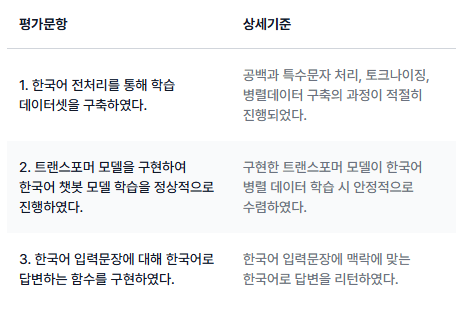